In [1]:
import tensorflow as tf    
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras
import os
warnings.filterwarnings("ignore")

In [2]:
train_dir = './train'

# Create a TensorFlow Dataset using image_dataset_from_directory
batch_size = 32
image_size = (224, 224)  # Resize images to this size
seed = 42  # Set a random seed for shuffling

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=image_size,
    #seed=seed,
    #validation_split=0.2,  # Split the dataset into training and validation sets
    #subset='training'  # Use the training subset
)

test_dir = './test'
val_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=image_size,
    #seed=seed,
    #validation_split=0.2,  # Split the dataset into training and validation sets
    #subset='validation'  # Use the validation subset
)

# Print class names and number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Class names:", class_names)
print("Number of classes:", num_classes)

# Now you can iterate over the train_dataset and val_dataset and train your model

Found 3095 files belonging to 6 classes.


2023-09-11 21:45:00.848627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 21:45:01.799798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11424 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:8a:00.0, compute capability: 6.1


Found 1323 files belonging to 6 classes.
Class names: ['Glioma', 'Meningioma', 'NORMAL', 'Neurocitoma', 'Outros Tipos de Lesões', 'Schwannoma']
Number of classes: 6


In [31]:
# train a vgg model to classify 17 classes with tensorflow
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from keras.optimizers import SGD
from keras.optimizers import Adam

# Load the VGG16 model pre-trained on ImageNet data
base_model = VGG19(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze all layers for classification
for layer in base_model.layers[:5]:
    layer.trainable = False

# Add a few layers for classification
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(6, activation='softmax') 
])

# Compile the model
#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
model.compile(optimizer=SGD(learning_rate=0.0009),
              loss='sparse_categorical_crossentropy',  # Since your labels are integers
              metrics=['accuracy'])

# Train the model
epochs = 20
hist = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print("Validation accuracy:", accuracy)

Epoch 1/20
97/97 [==============================] - 23s 227ms/step - loss: 1.9504 - accuracy: 0.3031 - val_loss: 1.5309 - val_accuracy: 0.3983
Epoch 2/20
97/97 [==============================] - 22s 228ms/step - loss: 1.4921 - accuracy: 0.3771 - val_loss: 1.4972 - val_accuracy: 0.3908
Epoch 3/20
97/97 [==============================] - 22s 227ms/step - loss: 1.3470 - accuracy: 0.4565 - val_loss: 1.3156 - val_accuracy: 0.4724
Epoch 4/20
97/97 [==============================] - 22s 227ms/step - loss: 1.1994 - accuracy: 0.5415 - val_loss: 1.2003 - val_accuracy: 0.5631
Epoch 5/20
97/97 [==============================] - 22s 228ms/step - loss: 1.0491 - accuracy: 0.6142 - val_loss: 1.0959 - val_accuracy: 0.5427
Epoch 6/20
97/97 [==============================] - 22s 228ms/step - loss: 0.8852 - accuracy: 0.6772 - val_loss: 0.8364 - val_accuracy: 0.7460
Epoch 7/20
97/97 [==============================] - 22s 228ms/step - loss: 0.7329 - accuracy: 0.7318 - val_loss: 0.5877 - val_accuracy: 0.8080

# Plot training results

### Accuracy/Loss/Recall

In [23]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)
    
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()


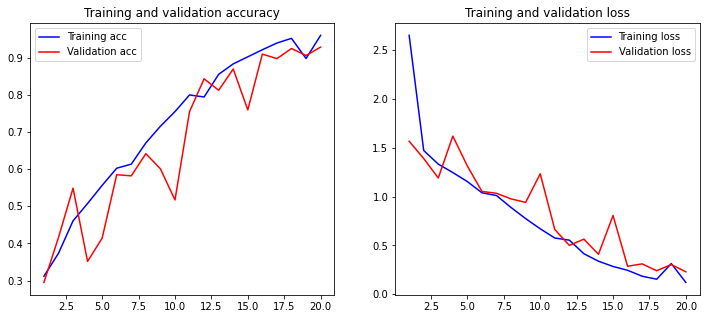

In [24]:
plot_history(hist)

# Confusion Matrix

In [25]:
# Get class names from the test dataset
class_names = val_dataset.class_names
from tensorflow.keras.utils import to_categorical

# Convert class names to class indices
class_indices = {class_name: index for index, class_name in enumerate(class_names)}

# Create a list of true labels (y_test) based on the file paths in the test_dataset
y_test = []
for images, labels in val_dataset:
    for label in labels:
        class_name = class_names[label]
        class_index = class_indices[class_name]
        y_test.append(class_index)

In [26]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
    #seed=seed,
    #validation_split=0.2,  # Split the dataset into training and validation sets
    #subset='validation'  # Use the validation subset
)

Found 1323 files belonging to 6 classes.


42/42 [==============================] - 4s 88ms/step


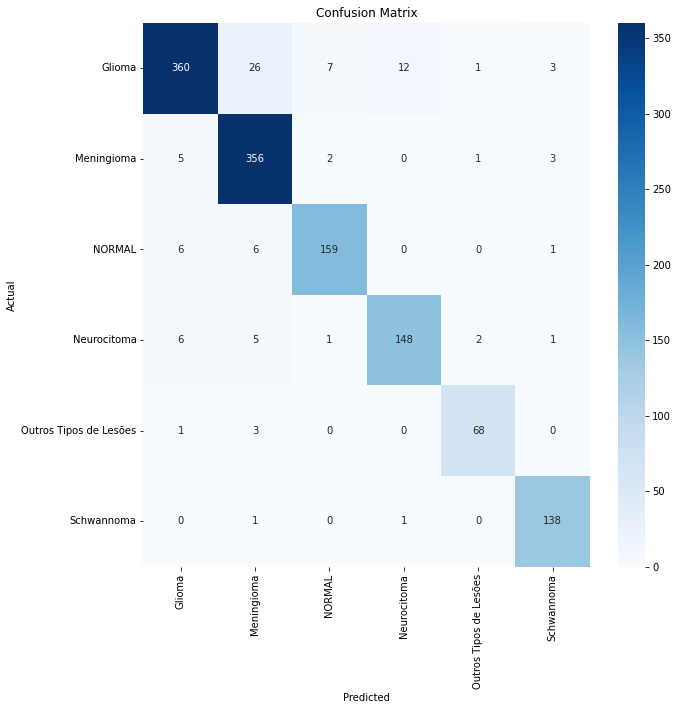

                        precision    recall  f1-score   support

                Glioma       0.88      0.95      0.91       378
            Meningioma       0.97      0.90      0.93       397
                NORMAL       0.92      0.94      0.93       169
           Neurocitoma       0.91      0.92      0.91       161
Outros Tipos de Lesões       0.94      0.94      0.94        72
            Schwannoma       0.99      0.95      0.97       146

              accuracy                           0.93      1323
             macro avg       0.94      0.93      0.93      1323
          weighted avg       0.93      0.93      0.93      1323



In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# make predictions
y_pred = model.predict(val_dataset)
y_pred = np.argmax(y_pred, axis=1)

# get confusion matrix
cm = confusion_matrix(y_pred, y_test)

# get classification report
cr = classification_report(y_test, y_pred, target_names=class_names)

# plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d',  cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# print classification report
print(cr)
